In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Load Azure ML workspace from config file
from azureml.core import Workspace
ws = Workspace.from_config()

# Print workspace details
print(ws.name, ws.location, ws.resource_group, sep="\n")

EkagraGupta
germanywestcentral
Personal


In [29]:
experiment_name = "pytorch-torchvision-mnist"       # Define a name for the experiment

# Create an experiment in the Azure ML workspace
from azureml.core import Experiment
experiment = Experiment(workspace=ws,
                 name=experiment_name)

In [30]:
from azureml.core.compute import AmlCompute, ComputeTarget
import os

# Define compute cluster configuration using environment variables or defaults
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")    # Name of the compute cluster
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)      # Min nodes in the compute cluster
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)      # Max nodes in the compute cluster
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")       # VM size of the compute cluster

# Verify that the cluster does not exist already
if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print(f"found compute target: {compute_name}")
else:
    # If the compute target doesn't exist, create a new one
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size=vm_size,                # VM size
                                                                min_nodes=compute_min_nodes,    # Min nodes
                                                                max_nodes=compute_max_nodes)    # Max nodes
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    print(compute_target.get_status().serialize())                          # Print the status of the compute target

found compute target: cpu-cluster


In [31]:
from azureml.core import Dataset

# Create a local directory to store the dataset
data_folder = os.path.join(os.getcwd(), "data")
os.makedirs(data_folder, exist_ok=True)                     # Create the directory if it doesn't exist

# Get the default datastore associated with the workspace
datastore = ws.get_default_datastore()

# Upload the local data folder to the datastore
datastore.upload(src_dir=data_folder,                       # Local directory to upload
                 target_path="torchvision-mnist-dataset",   # Target path in the datastore
                 overwrite=True)                            # Overwrite existing files

# Create a dataset from the uploaded data
dataset = Dataset.File.from_files(path=(datastore, "torchvision-mnist-dataset/"))

# Register the dataset in the workspace
registered_dataset = dataset.register(workspace=ws,                                                 # Azure ML workspace              
                                      name="torchvision-mnist-dataset",                             # Name of the dataset
                                      description="MNIST dataset from torchvision for training")    # Description of the dataset
print(f"dataset registered: {registered_dataset.name}")


Uploading an estimated of 8 files
Uploading /home/ekagra/Documents/GitHub/cifar10_azureml/data/MNIST/raw/t10k-labels-idx1-ubyte
Uploaded /home/ekagra/Documents/GitHub/cifar10_azureml/data/MNIST/raw/t10k-labels-idx1-ubyte, 1 files out of an estimated total of 8
Uploading /home/ekagra/Documents/GitHub/cifar10_azureml/data/MNIST/raw/train-labels-idx1-ubyte
Uploaded /home/ekagra/Documents/GitHub/cifar10_azureml/data/MNIST/raw/train-labels-idx1-ubyte, 2 files out of an estimated total of 8
Uploading /home/ekagra/Documents/GitHub/cifar10_azureml/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Uploaded /home/ekagra/Documents/GitHub/cifar10_azureml/data/MNIST/raw/t10k-labels-idx1-ubyte.gz, 3 files out of an estimated total of 8
Uploading /home/ekagra/Documents/GitHub/cifar10_azureml/data/MNIST/raw/train-labels-idx1-ubyte.gz
Uploaded /home/ekagra/Documents/GitHub/cifar10_azureml/data/MNIST/raw/train-labels-idx1-ubyte.gz, 4 files out of an estimated total of 8
Uploading /home/ekagra/Documents/GitHub/ci

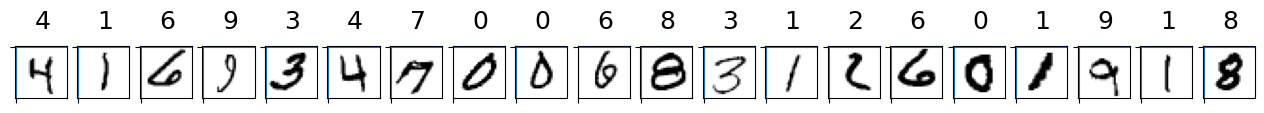

In [32]:
from utils import load_data             # Import the load_data function from the utils.py file
import glob

# Load training and test data from gzip files
xtrain = load_data(glob.glob(os.path.join(data_folder,"**/train-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.
ytrain = load_data(glob.glob(os.path.join(data_folder,"**/train-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

# Visualize a random sample of training images
count = 0
sample_size = 20
plt.figure(figsize=(16, 6))
for i in np.random.permutation(xtrain.shape[0])[:sample_size]:
    count += 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10,
             y=-10,
             s=ytrain[i],
             fontsize=18)
    plt.imshow(xtrain[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [33]:
# Define the script folder path and create the folder
script_folder = os.path.join(os.getcwd(), experiment_name)
os.makedirs(script_folder, exist_ok=True)

In [34]:
%%writefile $script_folder/train.py
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms

from azureml.core import Run

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Parse command-line arguments 
parser = argparse.ArgumentParser()
parser.add_argument("--data-folder", type=str, dest="data_folder", help="data doler mounting point")
parser.add_argument("--learning-rate", type=float, dest="lr", default=0.001, help="learning rate")
parser.add_argument("--weight decay", type=float, dest="weight_decay", default=0.0, help="weight decay (L2 regularization)")
parser.add_argument("--epochs", type=int, dest="epochs", default=5, help="Number of epochs to train the model for")
args = parser.parse_args()

# Extract arguments
data_folder = args.data_folder
epochs = args.epochs
lr = args.lr
wd = args.weight_decay
print(f"Data folder: {data_folder}")

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load MNIST data
trainset = datasets.MNIST(root=data_folder,
                          train=True,
                          download=True,
                          transform=transform)
testset = datasets.MNIST(root=data_folder,
                         train=False,
                         download=True,
                         transform=transform)

# Create data loaders
trainloader = DataLoader(trainset,
                            batch_size=64,
                            shuffle=True)
testloader = DataLoader(testset,
                        batch_size=64,
                        shuffle=False)

# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=lr,
                       weight_decay=wd)

# Get the Azure ML run context for logging
run = Run.get_context()

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader)}")


# Evaluate the model on the test set
model.eval()
ypred, ytrue = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        ypred.extend(predicted.numpy())
        ytrue.extend(labels.numpy())

# Calculate the accuracy
acc = accuracy_score(ytrue, ypred)
print(f"Accuracy is: {acc}")

# Log metrics to Azure ML
run.log("epochs", epochs)
run.log("accuracy", acc)

# Save the trained model
os.makedirs("outputs", exist_ok=True)
torch.save(model.state_dict(), "outputs/pytorch-torchvision-mnist-model.pth")

Overwriting /home/ekagra/Documents/GitHub/cifar10_azureml/pytorch-torchvision-mnist/train.py


In [35]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# Create an Azure ML environment
env = Environment("pytorch-torchvision-env")

# Define Conda and pip dependencies
cd = CondaDependencies.create(
    pip_packages=[
        'azureml-dataset-runtime[pandas,fuse]',  # Required for Azure ML datasets
        'azureml-defaults',                      # Required for Azure ML
        'torch==2.1.1',                          # Match local PyTorch version
        'torchvision==0.16.1',                   # Optional: If you're using torchvision
        'scikit-learn==1.5.1',                   # scikit-learn (for utilities like accuracy_score)
        'numpy==1.23.5',                         # NumPy
        'joblib==1.3.2',                         # joblib (for saving/loading models if needed)
    ],
    conda_packages=[
        'python==3.11.4',                        # Specify Python version
        'numpy==1.23.5'                          # NumPy (also available via Conda for better compatibility)
    ]
)

# Assign the dependencies to the environment
env.python.conda_dependencies = cd

# Register the environment in the workspace
env.register(workspace=ws)

{
    "assetId": "azureml://locations/germanywestcentral/workspaces/c36fd42d-501f-4209-bad2-0f8e70ac0288/environments/pytorch-torchvision-env/versions/3",
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:20241202.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "buildContext": null,
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "py

In [36]:
from azureml.core import ScriptRunConfig

# Define command-line arguments for the training script
args = ["--data-folder", registered_dataset.as_mount(),
        "--epochs", 5]

# Create a ScriptRunConfig to define the training job
src = ScriptRunConfig(source_directory=script_folder,
                      script="train.py",
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [37]:
# Submit the training job
run = experiment.submit(config=src)                 # Pass the ScriptRunConfig to the experiment
run                                                 # Display the run details (optional. for reference)

run.wait_for_completion(show_output=True)           # Wait for the run to complete and display live output

RunId: pytorch-torchvision-mnist_1737985310_005b2756
Web View: https://ml.azure.com/runs/pytorch-torchvision-mnist_1737985310_005b2756?wsid=/subscriptions/d96970c2-70d9-48fa-90ee-3efcb3a54b9a/resourcegroups/Personal/workspaces/EkagraGupta&tid=1c2c8b04-2ccf-429d-87a2-2a23ac882b5e

Streaming user_logs/std_log.txt

Data folder: /mnt/azureml/cr/j/f2e3a1551a8e4464b5f33e5cb7bd9d86/cap/data-capability/wd/INPUT_input__1b672ea2
Epoch 1/5, Loss: 0.20310483797232926
Epoch 2/5, Loss: 0.06440603196087764
Epoch 3/5, Loss: 0.044075894726019325
Epoch 4/5, Loss: 0.0344352607122823
Epoch 5/5, Loss: 0.029246852270450128
Accuracy is: 0.9904
Cleaning up all outstanding Run operations, waiting 300.0 seconds
1 items cleaning up...
Cleanup took 0.5575172901153564 seconds

Execution Summary
RunId: pytorch-torchvision-mnist_1737985310_005b2756
Web View: https://ml.azure.com/runs/pytorch-torchvision-mnist_1737985310_005b2756?wsid=/subscriptions/d96970c2-70d9-48fa-90ee-3efcb3a54b9a/resourcegroups/Personal/workspa

{'runId': 'pytorch-torchvision-mnist_1737985310_005b2756',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2025-01-27T13:42:21.318815Z',
 'endTimeUtc': '2025-01-27T13:45:54.465196Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlctrain',
  '_azureml.ClusterName': 'cpu-cluster',
  'ContentSnapshotId': '58cf5e03-1a2c-427c-a336-1359735bf518',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '1b672ea2-8002-4e23-b3ef-4942dd5725cd'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__1b672ea2', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder',
   'DatasetConsumptionConfig:input__1b672ea2',
   '--epochs',
   '5'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpu-cluste

In [38]:
print(run.get_metrics())                    # Get logged metrics
print(run.get_file_names())                 # Get the names of the files generated by the run

{'accuracy': 0.9904, 'epochs': 5}
['outputs/pytorch-torchvision-mnist-model.pth', 'system_logs/cs_capability/cs-capability.log', 'system_logs/data_capability/data-capability.log', 'system_logs/data_capability/rslex.log.2025-01-27-13', 'system_logs/hosttools_capability/hosttools-capability.log', 'system_logs/lifecycler/execution-wrapper.log', 'system_logs/lifecycler/lifecycler.log', 'system_logs/metrics_capability/metrics-capability.log', 'system_logs/snapshot_capability/snapshot-capability.log', 'user_logs/std_log.txt']


In [39]:
# Register the trained model in the workspace
model = run.register_model(model_name="pytorch-torchvision-mnist",
                           model_path="outputs/pytorch-torchvision-mnist-model.pth")

# Display the registered model details
print(model.name, model.id, model.version, sep="\n")

pytorch-torchvision-mnist
pytorch-torchvision-mnist:3
3


In [40]:
%%writefile score.py

import json
import numpy as np
import os
import torch
from torch import nn

# Define the same CNN model architecture used for training
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

# Initialize the model and load the trained weights
def init():
    global model
    model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "pytorch-torchvision-mnist-model.pth")
    model = SimpleCNN()
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))

# Ren inference on input data
def run(raw_data):
    model.eval()
    data = np.array(json.loads(raw_data)['data'])
    data = data.reshape(-1, 1, 28, 28)
    data_tensor = torch.tensor(data, dtype=torch.float32)

    with torch.no_grad():
        outputs = model(data_tensor)
        _, yhat = torch.max(outputs, 1)
    
    return yhat.tolist()

Overwriting score.py


In [41]:
from azureml.core.webservice import AciWebservice

# Define the deployment configuration for Azure Container Instances (ACI)
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1,
                                               memory_gb=1,
                                               tags={"data": "MNIST",
                                                     "method": "pytorch"},
                                                description="Predict MNIST with PyTorch loaded using Torchvision")

In [42]:
import uuid
from azureml.core.model import InferenceConfig, Model

# Retrive the registered model from the workspace
model = Model(ws, "pytorch-torchvision-mnist")

# Define the inference configuration
inference_config = InferenceConfig(entry_script="score.py",
                                   environment=env)

# Generate a unique service name
service_name = "pytorch-torchvision-svc" + str(uuid.uuid4())[:4]

# Deploy the model as a web service
service = Model.deploy(workspace=ws,
                       name=service_name,
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=aciconfig)

# Wait for the deployment to complete
service.wait_for_deployment(show_output=True)

/tmp/ipykernel_574308/2713621821.py:15: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'
  service = Model.deploy(workspace=ws,


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2025-01-27 14:46:43+01:00 Creating Container Registry if not exists.
2025-01-27 14:46:45+01:00 Use the existing image.
2025-01-27 14:46:45+01:00 Generating deployment configuration.
2025-01-27 14:46:47+01:00 Submitting deployment to compute.
2025-01-27 14:46:53+01:00 Checking the status of deployment pytorch-torchvision-svc484a..
2025-01-27 14:49:31+01:00 Checking the status of inference endpoint pytorch-torchvision-svc484a.
Succeeded
ACI service creation operation finished, operation "Succeeded"


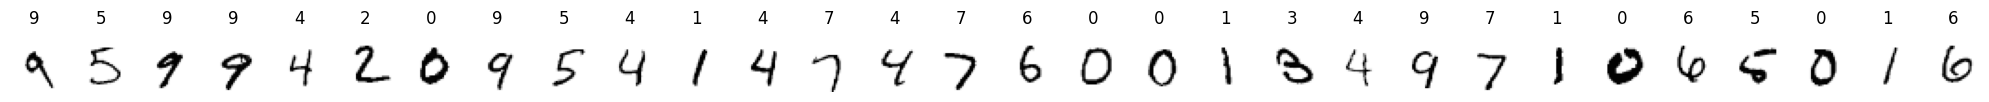

In [44]:
import json
import torch
from torchvision import datasets, transforms

# Define data transformation (convert images to tensor)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the test data
testset = datasets.MNIST(root=data_folder,
                         train=False,
                         download=True,
                         transform=transform)

# Truncate the test set to 30 samples for visualization
truncated_size = 30
truncated_testset = torch.utils.data.Subset(testset, range(truncated_size))

# Create a DataLoader for the truncated test set
testloader = torch.utils.data.DataLoader(truncated_testset,
                                         batch_size=64,
                                         shuffle=True)

# Get a batch of images and labels
images, labels = next(iter(testloader))

# Prepare input data for the web service
input_data = json.dumps({
    "data": images.tolist()
})
input_data = bytes(input_data, encoding='utf8')

# Send the data to the deployed web service and get the predictions
result = service.run(input_data=input_data)

# Visualize the results
plt.figure(figsize=(20, 3))
for i in range(truncated_size):
    plt.subplot(1, truncated_size, i + 1)
    plt.axis('off')
    
    font_color = 'red' if labels[i].item() != result[i] else 'black'
    clr_map = plt.cm.gray if labels[i].item() != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=str(result[i]), fontsize=12, color=font_color)
    plt.imshow(images[i].reshape(28, 28), cmap=clr_map)
plt.tight_layout()
plt.show()

In [45]:
# Delete the deployed web service
service.delete()

Running
2025-01-27 15:23:56+01:00 Check and wait for operation (37afbca6-3d51-44a3-8e99-1425f0d60eec) to finish.
2025-01-27 15:24:01+01:00 Deleting service entity.
Succeeded
